# Richter's Predictor

Initial code is a copy of the example found here: http://drivendata.co/blog/richters-predictor-benchmark/

We'll then use an XGBoost model to get a better estimate, and also will look at engineering some features using the geocode.

The intention is to try to find a way to use the fact that some areas (geo locations) will have suffered more damage than others.  There seem to be too many level 3 geolocations for a tree-based algorithm to deal with effectively, but if we can somehow uncover information about the geolocation and encode it in a way that is easier for the tree to deal with then it may improve our scores

In [111]:
%matplotlib inline

from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# for preprocessing the data
from sklearn.preprocessing import StandardScaler, LabelEncoder
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

# the model
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import confusion_matrix, f1_score, make_scorer
from sklearn.utils import class_weight

# for combining the preprocess with model training
from sklearn.pipeline import make_pipeline

# for optimizing the hyperparameters of the pipeline
from sklearn.model_selection import GridSearchCV

import itertools

from scipy.stats import ks_2samp



In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import xgboost as xgb

In [3]:
from xgboost import XGBClassifier

In [15]:
DATA_DIR = Path('.', 'data')

In [16]:
train_values = pd.read_csv(DATA_DIR / 'train_values.csv', index_col='building_id')
train_labels = pd.read_csv(DATA_DIR / 'train_labels.csv', index_col='building_id')
test_values  = pd.read_csv(DATA_DIR / 'test_values.csv', index_col='building_id')

In [17]:
train_index = train_values.index
test_index = test_values.index


#### We need to make sure we engineer features comparably across the train and test sets, so lets join them up here

In [18]:
test_and_train_values = pd.concat([train_values,test_values])

In [19]:
test_and_train_values.loc[test_index].shape

(86868, 38)

#### For some feature engineering we want to use the damage grades, so we'll join them here

In [20]:
test_and_train = test_and_train_values.join(train_labels)

In [21]:
test_and_train.loc[train_index].head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,...,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
building_id,,,,,,,,,,,,,,,,,,,,,
802906,6,487,12198,2,30,6,5,t,r,n,...,0,0,0,0,0,0,0,0,0,3.0
28830,8,900,2812,2,10,8,7,o,r,n,...,0,0,0,0,0,0,0,0,0,2.0
94947,21,363,8973,2,10,5,5,t,r,n,...,0,0,0,0,0,0,0,0,0,3.0
590882,22,418,10694,2,10,6,5,t,r,n,...,0,0,0,0,0,0,0,0,0,2.0
201944,11,131,1488,3,30,8,9,t,r,n,...,0,0,0,0,0,0,0,0,0,3.0


In [11]:
test_and_train.dtypes

geo_level_1_id                              int64
geo_level_2_id                              int64
geo_level_3_id                              int64
count_floors_pre_eq                         int64
age                                         int64
area_percentage                             int64
height_percentage                           int64
land_surface_condition                     object
foundation_type                            object
roof_type                                  object
ground_floor_type                          object
other_floor_type                           object
position                                   object
plan_configuration                         object
has_superstructure_adobe_mud                int64
has_superstructure_mud_mortar_stone         int64
has_superstructure_stone_flag               int64
has_superstructure_cement_mortar_stone      int64
has_superstructure_mud_mortar_brick         int64
has_superstructure_cement_mortar_brick      int64


## Data exploration

In [ ]:
(train_labels.damage_grade
             .value_counts()
             .sort_index()
             .plot.bar(title="Number of Buildings with Each Damage Grade"))

In [ ]:
secondary_uses = [
'has_secondary_use',
'has_secondary_use_agriculture',
'has_secondary_use_hotel',
'has_secondary_use_rental',
'has_secondary_use_institution',
'has_secondary_use_school',
'has_secondary_use_industry',
'has_secondary_use_health_post',
'has_secondary_use_gov_office',
'has_secondary_use_use_police',
'has_secondary_use_other'
]

structure = [
'has_superstructure_adobe_mud',
'has_superstructure_mud_mortar_stone',
'has_superstructure_stone_flag',
'has_superstructure_cement_mortar_stone',
'has_superstructure_mud_mortar_brick',
'has_superstructure_cement_mortar_brick',
'has_superstructure_timber',
'has_superstructure_bamboo',
'has_superstructure_rc_non_engineered',
'has_superstructure_rc_engineered',
'has_superstructure_other'
]



In [ ]:
for use in secondary_uses:
    print(use, train[train[use]==1]['damage_grade'].mean())

In [ ]:
for s in structure:
    print(s, train[train[s]==1]['damage_grade'].mean())

In [ ]:
biggest_geo3 = train['geo_level_3_id'].value_counts().head(30).index.values

In [ ]:
for location in biggest_geo3:
    print('Geo3 id:',location)
    for s in structure:
        s_filter = (train['geo_level_3_id'] == location) & (train[s] == 1)
        print(s, train.loc[s_filter]['damage_grade'].count(), train.loc[s_filter]['damage_grade'].mean())

### There are similarities in damage between the mortar types (mud/cement) and the reinforced concrete types (non-eng, engineered) so for the sake of our geoid indicator we'll group them

In [22]:

test_and_train['mud'] = test_and_train['has_superstructure_adobe_mud'] | test_and_train['has_superstructure_mud_mortar_stone'] | test_and_train['has_superstructure_mud_mortar_brick']
test_and_train['cement'] = test_and_train['has_superstructure_cement_mortar_stone'] | test_and_train['has_superstructure_cement_mortar_brick'] 
test_and_train['concrete'] = test_and_train['has_superstructure_rc_non_engineered'] | test_and_train['has_superstructure_rc_engineered'] 
test_and_train['natural'] = test_and_train['has_superstructure_timber'] | test_and_train['has_superstructure_bamboo'] 

test_and_train['n_struc_types'] = test_and_train['mud'] + test_and_train['cement'] + test_and_train['concrete'] + test_and_train['natural']

test_and_train['concrete_only'] = (test_and_train['concrete']==True) & (test_and_train['n_struc_types']==1)
test_and_train['cement_only'] = (test_and_train['cement']==True) & (test_and_train['n_struc_types']==1)

# This next one is just a helper column for use later to get averages of damage for each region
test_and_train['no-mud'] = abs(test_and_train['mud']-1)


In [ ]:
concrete_only = (train['concrete']==True) & (train['n_struc_types']==1)
mud_only = (train['mud']==True) & (train['n_struc_types']==1)
cement_only = (train['cement']==True) & (train['n_struc_types']==1)
natural_only = (train['natural']==True) & (train['n_struc_types']==1)


Observations about the building types:
* If building has some mud, damage is at least 2
* The distribution of damage isn't materially different whether the building is all mud or just has some mud.
* All-concrete buildings suffer very little damage
* All-cement are also strong, but not quite as good as all-concrete
* 

In [ ]:
(train[train['mud']==True].damage_grade
             .value_counts()
             .sort_index()
             .plot.bar(title="Number of mud Buildings with Each Damage Grade"))

In [ ]:
(train[mud_only].damage_grade
             .value_counts()
             .sort_index()
             .plot.bar(title="Number of mud only Buildings with Each Damage Grade"))

In [ ]:
(train[train['mud']==False].damage_grade
             .value_counts()
             .sort_index()
             .plot.bar(title="Number of non-mud Buildings with Each Damage Grade"))

In [ ]:
(train[train['natural']==True].damage_grade
             .value_counts()
             .sort_index()
             .plot.bar(title="Number of natural Buildings with Each Damage Grade"))

In [ ]:
(train[natural_only].damage_grade
             .value_counts()
             .sort_index()
             .plot.bar(title="Number of natural only Buildings with Each Damage Grade"))

In [ ]:
(train[train['cement']==True].damage_grade
             .value_counts()
             .sort_index()
             .plot.bar(title="Number of cement Buildings with Each Damage Grade"))

In [ ]:
(train[cement_only].damage_grade
             .value_counts()
             .sort_index()
             .plot.bar(title="Number of cement only Buildings with Each Damage Grade"))

In [ ]:
(train[(train['concrete']==True)].damage_grade
             .value_counts()
             .sort_index()
             .plot.bar(title="Number of concrete Buildings with Each Damage Grade"))

In [ ]:

(train[concrete_only].damage_grade
             .value_counts()
             .sort_index()
             .plot.bar(title="Number of concrete only Buildings with Each Damage Grade"))

In [ ]:
struc_types = ['mud','natural','cement','concrete']
combs = []
for i in range(len(struc_types)):
    combs.extend([list(t) for t in [k for k in itertools.combinations(struc_types,i+1)]])
    
combs

In [ ]:
filters = [train[t]==True for t in combs[12]]
train[np.logical_and.reduce(filters)].damage_grade.mean()

In [ ]:
np.logical_and.reduce(filters)

In [ ]:
for c in combs:
    filters = [train[t]==True for t in c]
    print(c)
    print(train[np.logical_and.reduce(filters)].damage_grade
             .mean())

In [ ]:
[list(t) for t in [k for k in itertools.combinations(struc_types,2)]]

### Damage measures for each geolocation

The idae here is that I want a normalised measure of average damage per geolocation.  The easiest way would be to take the average damage value for the geoid but that wouldn't take into consideration the different mix of building types.  If some geolocations had sturdier buildings then it's average damage might be artifically low.

So instead I'll take the average damage for each building type and/or some sort of adjustment for the building type - for example wooden buildings seem to have less damage so perhaps we can work out some normalised values for each building type and then combine them to get a single normalised damage value for each geoid.

The last factor I want to allow for is that some geoids have only one data point, and that isn't gong to be of much use, so instead my intial approach will be to take the average of the next geolevel up if the count of datapoints is below a certain threshold

### Some geolocations might only be in the test set, so if we are going to build a universal lookup then we need to include test as well so we can get a complete list

In [23]:
geo_lookup = test_and_train[['geo_level_3_id','geo_level_2_id','geo_level_1_id']].groupby(['geo_level_3_id']).first().reset_index()

In [24]:
geo_lookup.head()

,geo_level_3_id,geo_level_2_id,geo_level_1_id
0,0,179,12
1,1,194,15
2,2,657,0
3,3,73,30
4,4,1061,5


#### OK, now we can calcualte averages for each geoid level and construction type, and build our lookup table

We use train here because that df has got the damage values in it, but we use it a lot so at the start I will create an alias to it

In [ ]:
test_and_train.loc[train_index].head()

### Notes on following code
The code below was initially fallng back to geoid level 2 or level 1 if there was no value in the lower level, however I think there is a degree of overfitting happening as a result.  Most obviously, if there is only one example of a building type, and we use that for the avergage, then we are directly creating data leakage in the model! We are putting the answer into a 'feature' and the model learns to predict that result.  So instead, I've put thresholds (min 'n') in place to reduce data leakage.

In [26]:
levels = ['1','2','3']
structure_cats = ['mud','no-mud','cement_only', 'concrete_only']


for level in levels:
    print('averaging level',level)
    averages_list = []

    # Work out normalised damage grades for each structure type
    for s in structure_cats:
        s_filter = (test_and_train[s] == 1) & test_and_train.damage_grade.notnull()
        averages = test_and_train[s_filter].groupby('geo_level_'+level+'_id')['damage_grade'].agg({s+level+'_n':'count', 
                                     s+level+'_mean':'mean'})
        col_to_norm = averages[s+level+'_mean']
        averages[s+level+'_mean_norm']=(col_to_norm-col_to_norm.min())/(col_to_norm.max()-col_to_norm.min())
        #print(averages.head(2))
        averages_list.append(averages)

    # Concat the averages into one dataframe
    averages = pd.concat(averages_list, axis=1)
    
    # Now we have those, we can also calculate a weighted average across the structure types for that geoid
    
    norms = [s+level+'_mean_norm' for s in structure_cats]
    weights = [s+level+'_n' for s in structure_cats]

    norms_np = averages[norms].values
    weights_np = averages[weights].values

    # Here, I want to mask out where there are missing values (they are NaNs)
    weights_mask = np.isnan(weights_np)
    
    norms_np = np.ma.masked_array(norms_np, mask=weights_mask)
    weights_np = np.ma.masked_array(weights_np, mask=weights_mask)

    # Calculate the weighted average of the different building type normalised damage 
    wa_norm = np.ma.average(norms_np, weights=weights_np, axis=1)
    wa_norm.fill_value = np.nan
    
    # Now, I also want to mask out any results where the count is less than 3, to reduce data leakage.
    # First, sum up the weights_np values for each row, so we get total # of examples
    sum_of_norms = np.ma.sum(weights_np, axis=1)

    n_min = 3
    sum_of_norms_mask = ((sum_of_norms < n_min) | np.isnan(sum_of_norms))
    
    # Set those values of our results array to be masked 
    wa_norm[sum_of_norms_mask] = np.ma.masked

    # Finally, save the results into the averages array, filling any masked values with na.
    averages['level'+level+'norm_damage'] = wa_norm.filled()

    # Take the same approach on nud & no-mud mean norms, but a bit easier because we just have to create a filter then set the values
    mud_filter = averages['mud'+level+'_n'] < n_min
    averages.loc[mud_filter, 'mud'+level+'_mean_norm'] = np.nan
    
    nomud_filter = averages['no-mud'+level+'_n'] < n_min
    averages.loc[nomud_filter, 'no-mud'+level+'_mean_norm'] = np.nan
    
    #geo_lookup['level'+level+'_wa_norm_damage'] = wa_norm.filled()
    #print(averages.head())
    
    # Add on the columns we want to keep after all of that
    geo_lookup = geo_lookup.merge(averages['level'+level+'norm_damage'].reset_index(), how='left',on='geo_level_'+level+'_id')
    geo_lookup = geo_lookup.merge(averages['mud'+level+'_mean_norm'].reset_index(), how='left',on='geo_level_'+level+'_id')
    geo_lookup = geo_lookup.merge(averages['no-mud'+level+'_mean_norm'].reset_index(), how='left',on='geo_level_'+level+'_id')

print('Done')

averaging level 1
                mud1_n  mud1_mean  mud1_mean_norm  no-mud1_n  no-mud1_mean  \
geo_level_1_id                                                               
0                 3861   2.074333        0.175538        150      1.833333   
1                 2653   1.963815        0.056667         48      1.791667   
2                  891   2.187430        0.297182         40      1.600000   
3                 6979   2.383579        0.508155        561      1.684492   
4                14288   2.171683        0.280245        280      1.675000   

                no-mud1_mean_norm  cement_only1_n  cement_only1_mean  \
geo_level_1_id                                                         
0                        0.429796            80.0           1.862500   
1                        0.390150            14.0           1.714286   
2                        0.207781            12.0           1.916667   
3                        0.288174           229.0           1.812227   
4  

/Users/Andrew/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  del sys.path[0]


                mud2_n  mud2_mean  mud2_mean_norm  no-mud2_n  no-mud2_mean  \
geo_level_2_id                                                               
0                  1.0   3.000000             NaN       37.0      2.756757   
1                201.0   2.353234        0.676617        3.0      2.000000   
3                 77.0   2.103896        0.551948        NaN           NaN   
4                305.0   2.537705        0.768852       10.0      2.000000   
5                 25.0   2.160000        0.580000        NaN           NaN   

                no-mud2_mean_norm  cement_only2_n  cement_only2_mean  \
geo_level_2_id                                                         
0                        0.878378             1.0                3.0   
1                        0.500000             1.0                2.0   
3                             NaN             NaN                NaN   
4                        0.500000             3.0                2.0   
5                    

In [ ]:
averages.head(15)

In [ ]:
k = np.array([np.nan, 3, 1, 2, np.nan, 5])

In [ ]:
l = np.array([0.32, 5.32, 0.97, 0.12, 2, 10])

In [ ]:
k

In [ ]:
l

In [ ]:
l[(k < 2) | np.isnan(k)] = np.nan

In [ ]:
k

In [ ]:
l

### Some  geoids have missing values though, presumably because the only examples are in the training set.  So we can use the next available level up

In [33]:
geo_lookup.loc[8318]

geo_level_3_id       8805.000000
geo_level_2_id        307.000000
geo_level_1_id         12.000000
level1norm_damage       0.263758
mud1_mean_norm          0.261661
no-mud1_mean_norm       0.482656
level2norm_damage       0.590909
mud2_mean_norm          0.590909
no-mud2_mean_norm            NaN
level3norm_damage       0.666667
mud3_mean_norm          0.666667
no-mud3_mean_norm            NaN
Name: 8318, dtype: float64

In [34]:
empty_level = geo_lookup['level2norm_damage'].isnull()
geo_lookup.loc[empty_level,'level2norm_damage'] = geo_lookup.loc[empty_level,'level1norm_damage']

empty_level = geo_lookup['level3norm_damage'].isnull()
geo_lookup.loc[empty_level,'level3norm_damage'] = geo_lookup.loc[empty_level,'level2norm_damage']


empty_level = geo_lookup['mud2_mean_norm'].isnull()
geo_lookup.loc[empty_level,'mud2_mean_norm'] = geo_lookup.loc[empty_level,'mud1_mean_norm']

empty_level = geo_lookup['mud3_mean_norm'].isnull()
geo_lookup.loc[empty_level,'mud3_mean_norm'] = geo_lookup.loc[empty_level,'mud2_mean_norm']


empty_level = geo_lookup['no-mud2_mean_norm'].isnull()
geo_lookup.loc[empty_level,'no-mud2_mean_norm'] = geo_lookup.loc[empty_level,'no-mud1_mean_norm']

empty_level = geo_lookup['no-mud3_mean_norm'].isnull()
geo_lookup.loc[empty_level,'no-mud3_mean_norm'] = geo_lookup.loc[empty_level,'no-mud2_mean_norm']



In [35]:
geo_lookup.loc[8318]

geo_level_3_id       8805.000000
geo_level_2_id        307.000000
geo_level_1_id         12.000000
level1norm_damage       0.263758
mud1_mean_norm          0.261661
no-mud1_mean_norm       0.482656
level2norm_damage       0.590909
mud2_mean_norm          0.590909
no-mud2_mean_norm       0.482656
level3norm_damage       0.666667
mud3_mean_norm          0.666667
no-mud3_mean_norm       0.482656
Name: 8318, dtype: float64

### Finally, join the lookup table with the test/train values

In [36]:
# In order to preserve the index we:
#  First, reset the index(!) which moves the index to col named 'building_id'
#  Then after the merge, we set the index of the df to be the col named 'building_id', restoring the original index
test_and_train = test_and_train.reset_index().merge(geo_lookup[['geo_level_3_id','level3norm_damage','mud3_mean_norm','no-mud3_mean_norm']], on=['geo_level_3_id'], how='left').set_index('building_id')

In [37]:
test_and_train.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,...,cement,concrete,natural,n_struc_types,concrete_only,cement_only,no-mud,level3norm_damage,mud3_mean_norm,no-mud3_mean_norm
building_id,,,,,,,,,,,,,,,,,,,,,
802906,6,487,12198,2,30,6,5,t,r,n,...,0,0,0,1,False,False,0,0.918919,0.918919,0.416667
28830,8,900,2812,2,10,8,7,o,r,n,...,0,0,0,1,False,False,0,0.500000,0.566667,0.166667
94947,21,363,8973,2,10,5,5,t,r,n,...,0,0,0,1,False,False,0,0.771127,0.820312,0.312500
590882,22,418,10694,2,10,6,5,t,r,n,...,0,0,1,2,False,False,0,0.548387,0.571429,0.333333
201944,11,131,1488,3,30,8,9,t,r,n,...,0,0,0,1,False,False,0,0.680000,0.690265,0.611111


In [38]:
# Double check we haven't broken anything
test_and_train.loc[test_index].head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,...,cement,concrete,natural,n_struc_types,concrete_only,cement_only,no-mud,level3norm_damage,mud3_mean_norm,no-mud3_mean_norm
building_id,,,,,,,,,,,,,,,,,,,,,
300051,17,596,11307,3,20,7,6,t,r,n,...,0,0,0,1,False,False,0,0.775000,0.861111,0.717100
99355,6,141,11987,2,25,13,5,t,r,n,...,0,0,0,1,False,False,0,0.500000,0.500000,0.021434
890251,22,19,10044,2,5,4,5,t,r,n,...,0,0,0,1,False,False,0,0.581633,0.596774,0.555556
745817,26,39,633,1,0,19,3,t,r,x,...,1,0,0,1,False,True,1,0.211715,0.428571,0.214286
421793,17,289,7970,3,15,8,7,t,r,q,...,0,0,0,1,False,False,0,0.911765,0.911765,0.478261


### OHE the categorical columns

In [39]:
categorical_columns = [
    'land_surface_condition',
    'foundation_type',
    'roof_type',
    'ground_floor_type',
    'other_floor_type',
    'position',
    'plan_configuration',
    'legal_ownership_status'
]

In [40]:
for col in categorical_columns:
    test_and_train[col] = pd.Categorical(test_and_train[col])
    dfDummies = pd.get_dummies(test_and_train[col], prefix = col)
    test_and_train = pd.concat([test_and_train, dfDummies], axis=1)

In [41]:
test_and_train = test_and_train.drop(categorical_columns, axis=1)


In [47]:
test_and_train = test_and_train.drop('no-mud', axis=1)

# Examine the data we now have

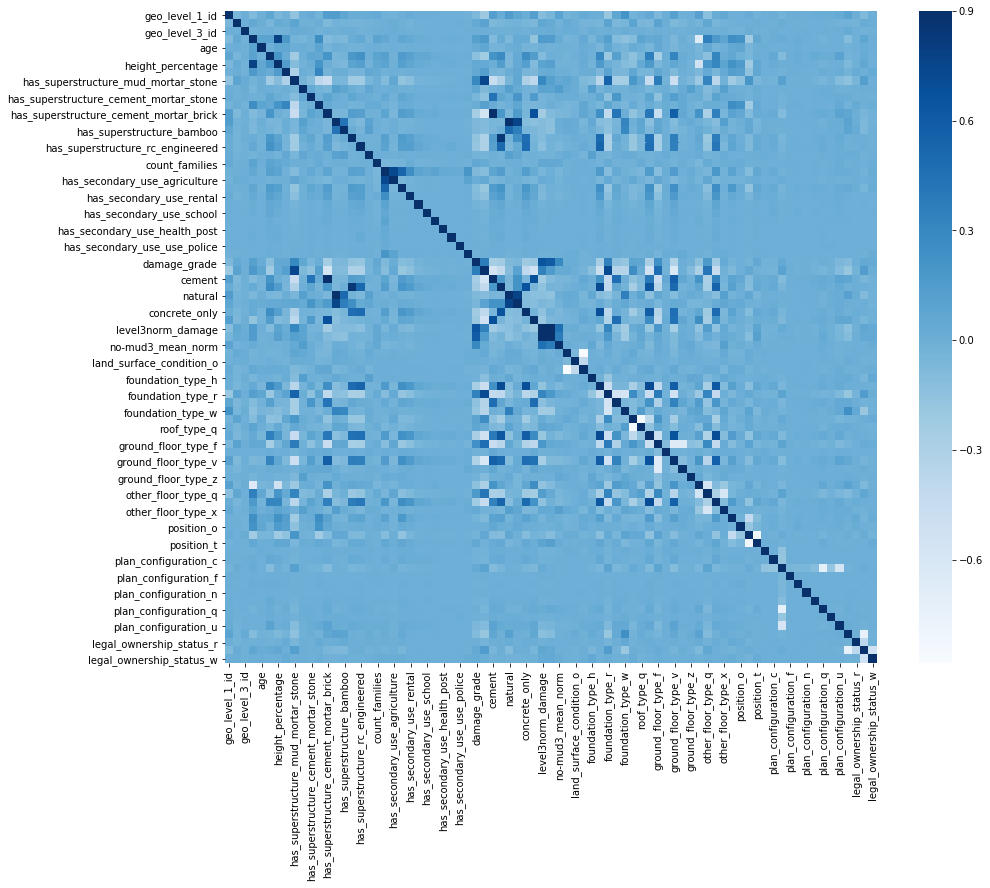

In [48]:
corr = test_and_train.corr()
plt.subplots(figsize=(15,12))
sns.heatmap(corr, vmax=0.9, cmap="Blues", square=True)

In [49]:
#Correlation with output variable
cor_target = abs(corr["damage_grade"])


In [50]:
cor_target

geo_level_1_id              0.072347
geo_level_2_id              0.043161
geo_level_3_id              0.007932
count_floors_pre_eq         0.122308
age                         0.029273
                              ...   
plan_configuration_u        0.062317
legal_ownership_status_a    0.082705
legal_ownership_status_r    0.002591
legal_ownership_status_v    0.048238
legal_ownership_status_w    0.029555
Name: damage_grade, Length: 79, dtype: float64

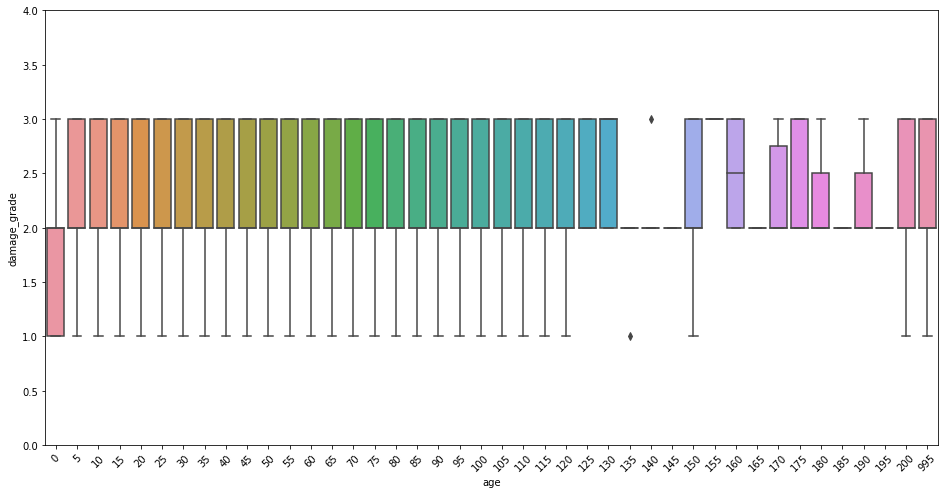

In [51]:
data = pd.concat([test_and_train.loc[train_index,'damage_grade'], test_and_train.loc[train_index,'age']], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=test_and_train.loc[train_index,'age'], y="damage_grade", data=data)
fig.axis(ymin=0, ymax=4);
plt.xticks(rotation=45);

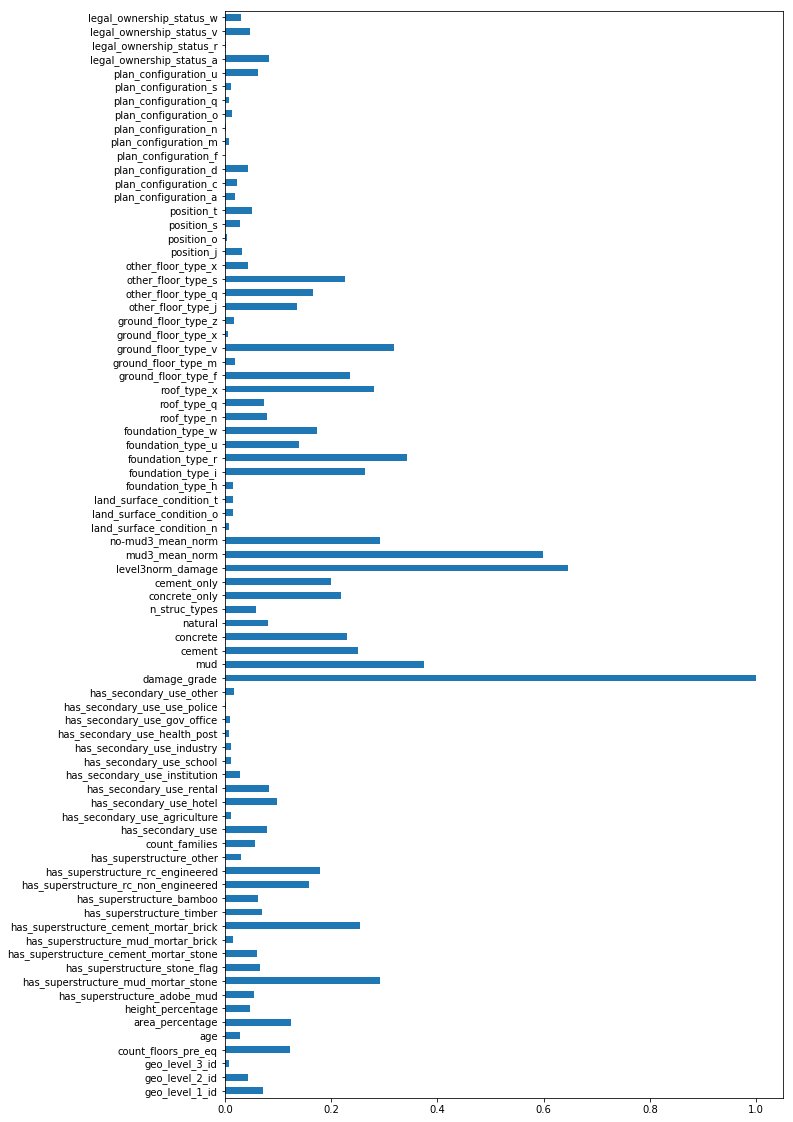

In [52]:
cor_target.plot(kind='barh',figsize=(10,20))

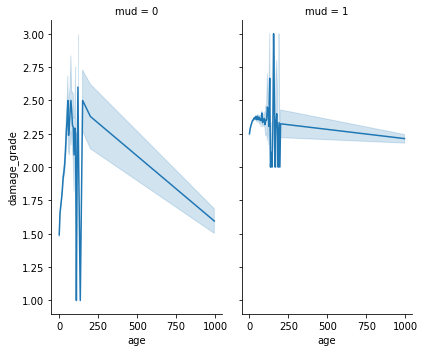

In [53]:
sns.relplot(x="age", y="damage_grade",col="mud", aspect=.6,kind="line", data=test_and_train.loc[train_index]);

In [54]:
test_and_train["age_l"] = np.log1p(test_and_train["age"])
test_and_train["age_l"] = test_and_train["age_l"].round(decimals=0)

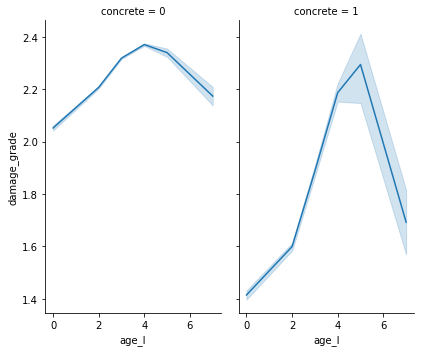

In [55]:
sns.relplot(x="age_l", y="damage_grade",col="concrete", aspect=.6,kind="line", data=test_and_train.loc[train_index]);

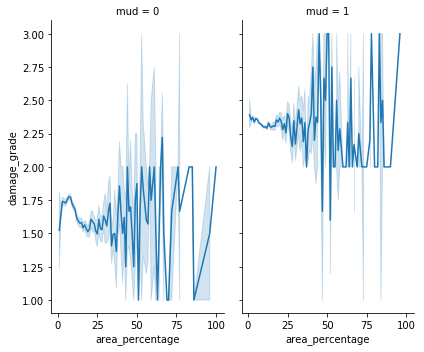

In [56]:
sns.relplot(x="area_percentage", y="damage_grade",col="mud", aspect=.6,kind="line", data=test_and_train.loc[train_index]);

In [57]:
test_and_train["area_pc"] = np.log1p(test_and_train["area_percentage"])
test_and_train["area_pc"] = test_and_train["area_pc"].round(decimals=1)

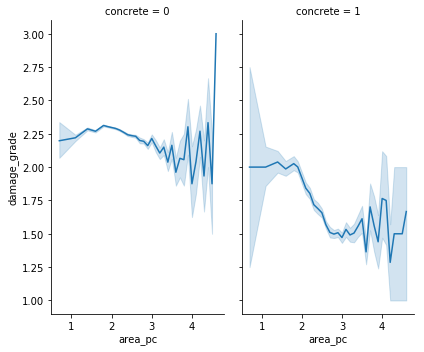

In [58]:
sns.relplot(x="area_pc", y="damage_grade",col="concrete", aspect=.6,kind="line", data=test_and_train.loc[train_index]);

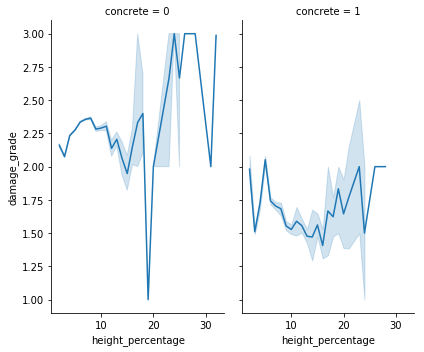

In [59]:
sns.relplot(x="height_percentage", y="damage_grade",col="concrete", aspect=.6,kind="line", data=test_and_train.loc[train_index]);

In [60]:
test_and_train["height_pc"] = np.log1p(test_and_train["height_percentage"])
test_and_train["height_pc"] = test_and_train["height_pc"].round(decimals=1)

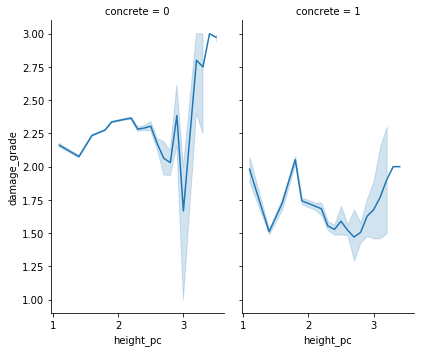

In [61]:
sns.relplot(x="height_pc", y="damage_grade",col="concrete", aspect=.6,kind="line", data=test_and_train.loc[train_index]);

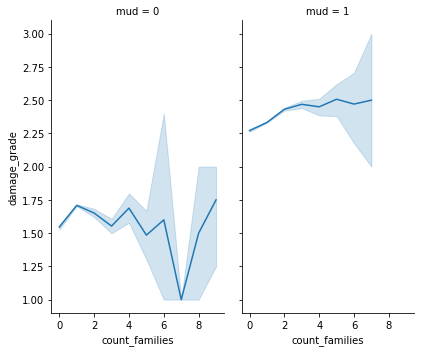

In [62]:
sns.relplot(x="count_families", y="damage_grade",col="mud", aspect=.6,kind="line", data=test_and_train.loc[train_index]);

## Test vs Train

## Train Test Split

In [129]:
#train_ex_geo = test_and_train.loc[train_index].drop(['geo_level_1_id','geo_level_2_id','geo_level_3_id', 'damage_grade'], axis=1)
train_ex_geo = test_and_train.loc[train_index].drop(['geo_level_2_id','geo_level_3_id', 'damage_grade'], axis=1)


In [130]:
X_train, X_test, y_train, y_test = train_test_split(train_ex_geo, test_and_train.loc[train_index,'damage_grade'], test_size=0.2)


In [65]:
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)

In [66]:
class_weights

array([3.45257022, 0.58620418, 0.99554944])

## Try random forest classifier

In [67]:
clf = RandomForestClassifier(n_estimators=1500,
                          max_depth=15,
                          min_samples_split=5,
                          min_samples_leaf=5,
                          max_features=None,
                          oob_score=True)#, class_weight='balanced')
%time clf.fit(X_train, y_train) 

CPU times: user 37min 14s, sys: 10.1 s, total: 37min 24s
Wall time: 37min 26s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=15, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=1500,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

In [68]:
print(list(zip(X_train.columns,clf.feature_importances_)))

[('count_floors_pre_eq', 0.004293554713446256), ('age', 0.028298221898975365), ('area_percentage', 0.015872188795488858), ('height_percentage', 0.00780567760809007), ('has_superstructure_adobe_mud', 0.0011288987158655415), ('has_superstructure_mud_mortar_stone', 0.0018225305142179026), ('has_superstructure_stone_flag', 0.000564383319584492), ('has_superstructure_cement_mortar_stone', 0.0005258593041075079), ('has_superstructure_mud_mortar_brick', 0.001958919177515945), ('has_superstructure_cement_mortar_brick', 0.001395275454439148), ('has_superstructure_timber', 0.0015066721810878304), ('has_superstructure_bamboo', 0.001649205867611819), ('has_superstructure_rc_non_engineered', 0.0007327553706524607), ('has_superstructure_rc_engineered', 0.0011564915783339705), ('has_superstructure_other', 0.000551695997036754), ('count_families', 0.005636971622536781), ('has_secondary_use', 0.002976240524259449), ('has_secondary_use_agriculture', 0.0008938824691470681), ('has_secondary_use_hotel', 0.

In [69]:

y_pred = clf.predict(X_test)
f1_score(y_test, y_pred, average='micro')

0.7568734291360488

#### Train on full dataset and predict probabilities so we can combine predictions across models

In [ ]:
%time clf.fit(train_ex_geo, train['damage_grade']) 

## Select only a few of the columns

In [70]:
cols_to_use = [
    'level3norm_damage',
    'mud3_mean_norm',
    'no-mud3_mean_norm',
    'mud',
    'cement_only',
    'concrete_only',
    'count_floors_pre_eq',
    'age_l',
    'foundation_type',
    'roof_type',
    'area_pc',
    'height_pc',
    'ground_floor_type'
]



In [71]:
filter_col = []
for col_prefix in cols_to_use:
    filter_col.extend([col for col in X_train if col.startswith(col_prefix)])

#It's possible to get repeats here, so I'll clean up after the fact. Should start with set instead to avoid the issue.
filter_col = list(set(filter_col))

In [72]:
filter_col

['mud',
 'foundation_type_i',
 'ground_floor_type_m',
 'area_pc',
 'foundation_type_h',
 'ground_floor_type_f',
 'foundation_type_r',
 'concrete_only',
 'age_l',
 'roof_type_n',
 'cement_only',
 'ground_floor_type_x',
 'ground_floor_type_z',
 'mud3_mean_norm',
 'roof_type_x',
 'no-mud3_mean_norm',
 'foundation_type_w',
 'roof_type_q',
 'level3norm_damage',
 'ground_floor_type_v',
 'count_floors_pre_eq',
 'height_pc',
 'foundation_type_u']

In [73]:
X_train, X_test, y_train, y_test = train_test_split(test_and_train.loc[train_index,filter_col],
                                                    test_and_train.loc[train_index,'damage_grade'], test_size=0.15)


In [74]:
clf1 = RandomForestClassifier(n_estimators=1500,
                          max_depth=15,
                          min_samples_split=5,
                          min_samples_leaf=5,
                          max_features=None,
                          oob_score=True)#, class_weight='balanced')


In [75]:
%time clf1.fit(X_train, y_train) 

CPU times: user 15min 17s, sys: 6.18 s, total: 15min 23s
Wall time: 15min 23s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=15, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=1500,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

In [76]:
y_pred = clf1.predict(X_test)
f1_score(y_test, y_pred, average='micro')

0.7552121971809368

In [77]:
confusion_matrix(y_test,y_pred)

array([[ 2081,  1602,    46],
       [  821, 18763,  2469],
       [  101,  4530,  8678]])

#### Train on full data set

In [ ]:
%time clf1.fit(train_select_cols, train['damage_grade']) 

In [ ]:
confusion_matrix(y_test,y_pred)

In [ ]:
clf = RandomForestClassifier(n_estimators=500, max_depth=15, class_weight={1:1.5,2:1,3:1.2})
%time clf.fit(X_train, y_train) 

In [ ]:
y_pred = clf.predict(X_test)
f1_score(y_test, y_pred, average='micro')

In [ ]:
confusion_matrix(y_test,y_pred)

### Linear Discriminant

In [ ]:
clfLD = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')
%time clfLD.fit(X_train, y_train) 

In [ ]:
y_predLD = clfLD.predict(X_test)
f1_score(y_test, y_predLD, average='micro')

### KNeighbours

In [ ]:
clf_k = KNeighborsClassifier(15)
%time clf_k.fit(X_train, y_train) 

In [ ]:
y_pred_k = clf_k.predict(X_test)
f1_score(y_test, y_pred_k, average='micro')

## OK, now let's try that with XGBoost on the smaller dataset

In [ ]:
X_train.columns

In [ ]:
# read in data
dtrain = xgb.DMatrix(X_train, label=y_train-1)
dtest = xgb.DMatrix(X_test, label=y_test-1)


In [ ]:
# specify parameters via map
param = {'max_depth':6, 'eta':0.1, 'subsample':1, 'objective':'multi:softmax', 'num_class':3}
num_round = 200


In [ ]:
f1_micro = make_scorer(f1_score, average='micro')

def f1_eval(y_pred, dtrain):
    y_true = dtrain.get_label()
    err = 1-f1_score(y_true, np.argmax(y_pred, axis=1), average='micro')
    return 'f1_err', err


In [ ]:
clf_xgb = XGBClassifier(n_estimators=1500,gamma=5, learning_rate=0.1, max_delta_step=0, max_depth=15,
                        min_child_weight=3)
eval_set = [(X_train, y_train-1), (X_test, y_test-1)]
clf_xgb.fit(X_train, y_train-1, eval_set=eval_set, verbose=True, early_stopping_rounds=150)
#

In [ ]:
# retrieve performance metrics
results = clf_xgb.evals_result()
epochs = len(results['validation_0']['merror'])
x_axis = range(0, epochs)
# plot f1 error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
plt.ylabel('F1 micro')
plt.title('XGBoost F1 micro')
plt.show()


In [ ]:
# make prediction
y_predXG = clf_xgb.predict(X_test) + 1

In [ ]:
f1_score(y_test, y_predXG, average='micro')

In [ ]:
subsample = [0.3, 0.8]
param_grid = dict(subsample=subsample)
#kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
grid_search = GridSearchCV(clf_xgb, param_grid, scoring=f1_micro, n_jobs=-1, cv=2)
grid_result = grid_search.fit(X_train.values, y_train.values-1)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))


In [ ]:
# plot
plt.errorbar(subsample, means, yerr=stds)
plt.title("XGBoost subsample vs Log Loss")
plt.xlabel('subsample')
plt.ylabel('Log Loss')
plt.savefig('subsample.png')


### Use some settings from here:
https://www.kaggle.com/lavanyashukla01/how-i-made-top-0-3-on-a-kaggle-competition

learning_rate=0.01,
n_estimators=6000,
max_depth=4,
min_child_weight=0,
gamma=0.6,
subsample=0.7,
colsample_bytree=0.7,
objective='reg:linear',
nthread=-1,
scale_pos_weight=1,
seed=27,
reg_alpha=0.00006,
random_state=42

In [131]:
clf_xgb = XGBClassifier(n_estimators=10000,gamma=0.6, learning_rate=0.1, max_depth=12,
                        min_child_weight=0, subsample=0.7, colsample_bytree=0.7,
                        scale_pos_weight=1, reg_alpha=0.00006)
eval_set = [(X_train, y_train-1), (X_test, y_test-1)]
clf_xgb.fit(X_train, y_train-1, eval_set=eval_set, verbose=True, early_stopping_rounds=150)

[0]	validation_0-merror:0.227701	validation_1-merror:0.25011
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 150 rounds.
[1]	validation_0-merror:0.219446	validation_1-merror:0.243031
[2]	validation_0-merror:0.217105	validation_1-merror:0.241381
[3]	validation_0-merror:0.215378	validation_1-merror:0.240652
[4]	validation_0-merror:0.214894	validation_1-merror:0.240325
[5]	validation_0-merror:0.21428	validation_1-merror:0.239922
[6]	validation_0-merror:0.213483	validation_1-merror:0.239616
[7]	validation_0-merror:0.212893	validation_1-merror:0.239731
[8]	validation_0-merror:0.212337	validation_1-merror:0.239193
[9]	validation_0-merror:0.211733	validation_1-merror:0.238675
[10]	validation_0-merror:0.211152	validation_1-merror:0.238752
[11]	validation_0-merror:0.210452	validation_1-merror:0.238464
[12]	validation_0-merror:0.209641	validation_1-merror:0.238234
[13]	validation_0-merror:0.20

[128]	validation_0-merror:0.16131	validation_1-merror:0.23716
[129]	validation_0-merror:0.160965	validation_1-merror:0.237141
[130]	validation_0-merror:0.160553	validation_1-merror:0.237064
[131]	validation_0-merror:0.160318	validation_1-merror:0.237236
[132]	validation_0-merror:0.159809	validation_1-merror:0.237428
[133]	validation_0-merror:0.159584	validation_1-merror:0.237332
[134]	validation_0-merror:0.159349	validation_1-merror:0.23739
[135]	validation_0-merror:0.15907	validation_1-merror:0.237524
[136]	validation_0-merror:0.158864	validation_1-merror:0.237505
[137]	validation_0-merror:0.158423	validation_1-merror:0.237332
[138]	validation_0-merror:0.157991	validation_1-merror:0.237601
[139]	validation_0-merror:0.157651	validation_1-merror:0.237812
[140]	validation_0-merror:0.157344	validation_1-merror:0.23785
[141]	validation_0-merror:0.156974	validation_1-merror:0.237505
[142]	validation_0-merror:0.156778	validation_1-merror:0.237582
[143]	validation_0-merror:0.156303	validation

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=0.7, gamma=0.6, learning_rate=0.1,
              max_delta_step=0, max_depth=12, min_child_weight=0, missing=None,
              n_estimators=10000, n_jobs=1, nthread=None,
              objective='multi:softprob', random_state=0, reg_alpha=6e-05,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
              subsample=0.7)

### Train on full(ish) dataset
Reducing the test/validation set right down in an attempt to give the model more data to train with

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(test_and_train.loc[train_index,filter_col],
                                                    test_and_train.loc[train_index,'damage_grade'], test_size=0.05)
eval_set = [(X_train, y_train-1), (X_test, y_test-1)]

In [ ]:
# Change to softprob so that we get the probabilities, which allows us to ensemble with the other models
#param = {'max_depth':6, 'eta':0.3, 'subsample':1, 'objective':'multi:softprob', 'num_class':3 }
#%time clfXGB = xgb.train(param, dtrain_full, num_round)

In [ ]:
clf_xgb.fit(X_train, y_train-1, eval_set=eval_set, verbose=True, early_stopping_rounds=150)


In [ ]:
test_and_train.loc[train_index,'damage_grade'].shape

In [ ]:
y_test[:10]

In [ ]:
y_pred[:20]

In [ ]:
y_predXG[:20]

In [ ]:
y_predLD[:20]

## And XGBoost on all features

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_ex_geo, train['damage_grade'], test_size=0.2)


In [ ]:
# read in data
dtrain = xgb.DMatrix(X_train, label=y_train-1)
dtest = xgb.DMatrix(X_test, label=y_test-1)


In [ ]:
# specify parameters via map
param = {'max_depth':10, 'eta':0.3, 'subsample':1, 'objective':'multi:softmax', 'num_class':3 }
num_round = 200


In [ ]:
%time bst = xgb.train(param, dtrain, num_round)


In [ ]:
# make prediction
y_predXG = bst.predict(dtest) + 1

In [ ]:
f1_score(y_test, y_predXG, average='micro')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_ex_geo, train['damage_grade'], test_size=0)

In [ ]:
dtrain = xgb.DMatrix(X_train, label=y_train-1)


In [ ]:
bst = xgb.train(param, dtrain, num_round)


## Also try imbalance XGBoost
Can't get past the errors

In [ ]:
from imxgboost.imbalance_xgb import imbalance_xgboost as imb_xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut , cross_validate

# focal XGBoost
xgboster_focal = imb_xgb(special_objective='focal')
# cross - validation booster
CV_focal_booster = GridSearchCV ( xgboster_focal , {"focal_gamma":[1.0 , 2.0 , 3.0]})
# fit the booster
CV_focal_booster . fit (X_train.values , y_train.values )
# retrieve the best model and parameter
opt_focal_booster = CV_focal_booster . best_estimator_
opt_focal_parameter = CV_focal_booster . best_params_
# instantialize an imbalance - xgboost instance for cross - validation
xgboost_focal_opt = imb_xgb (special_objective='focal', ** xgboost_opt_param )
# initialize a leave -one splitter
loo_splitter = LeaveOneOut ()
# Leave - One cross validation
loo_info_dict = cross_validate ( xgboost_focal_opt , X=X_train , y=y_train-1 , cv= loo_splitter )

## Try grid search with XGBoost

In [ ]:
xgb_grid = XGBClassifier(learning_rate=0.3, n_estimators=600, objective='multi:softmax',
                    silent=False, nthread=1)

In [ ]:
grid_params = {
    'max_depth' : [5,7,10,13],
#    'gamma': [0, 0.2],
#    'subsample': [0.8, 1],
}


In [ ]:
f1_micro = make_scorer(f1_score, average='micro')


In [ ]:
grid = GridSearchCV(estimator=xgb_grid, param_grid=grid_params, scoring=f1_micro, n_jobs=-1, cv=2, verbose=10 )
grid.fit(X_train, y_train-1)
print('\n All results:')
print(grid.cv_results_)
print('\n Best estimator:')
print(grid.best_estimator_)
print('\n Best score:')
print(grid.best_score_ * 2 - 1)
print('\n Best parameters:')
print(grid.best_params_)
results = pd.DataFrame(grid.cv_results_)


In [ ]:
xgb_classifier = XGBClassifier(learning_rate=0.1, n_estimators=600, objective='multi:softmax',
                    silent=False, nthread=-1, max_depth=15)

In [ ]:
%time xgb_classifier.fit(X_train, y_train-1)

In [ ]:
y_pred_XGBC = xgb_classifier.predict(X_test)


In [ ]:
 f1_score(y_test, y_pred_XGBC+1, average='micro')

## Make a submission

In [133]:
method = 3

if method == 1:
    test_ex_geo = test_values.drop(['geo_level_1_id','geo_level_2_id','geo_level_3_id'], axis=1)
    dtest = xgb.DMatrix(test_ex_geo)
    y_pred = bst.predict(dtest) + 1
    
elif method == 2:
    y_pred = clf_xgb.predict(test_and_train.loc[test_index,filter_col]) +1
    
elif method == 3:
    y_pred = clf_xgb.predict(test_and_train.loc[test_index].drop(['geo_level_2_id','geo_level_3_id', 'damage_grade'], axis=1)) +1
    

    

In [134]:
y_pred[:10]

array([3., 2., 2., 1., 3., 2., 2., 3., 2., 2.])

In [135]:
submission_format = pd.read_csv(DATA_DIR / 'submission_format.csv', index_col='building_id')


In [136]:
my_submission = pd.DataFrame(data=y_pred,
                             columns=submission_format.columns,
                             index=submission_format.index)


In [137]:
my_submission.head()

,damage_grade
building_id,
300051,3.0
99355,2.0
890251,2.0
745817,1.0
421793,3.0


In [138]:
my_submission.damage_grade = my_submission.damage_grade.astype(int)

In [139]:
my_submission.head()

,damage_grade
building_id,
300051,3
99355,2
890251,2
745817,1
421793,3


In [140]:
my_submission.to_csv('submission.csv')

In [ ]:
!head submission.csv

### Make Ensemble submission

In [ ]:
test_ex_geo = test_values.drop(['geo_level_1_id','geo_level_2_id','geo_level_3_id'], axis=1)
#test_small = test_values[cols_to_use]
test_xgb = xgb.DMatrix(test_ex_geo)

In [ ]:
y_pred_rf_full = clf.predict_proba(test_ex_geo)   
#y_pred_rf_small = clf1.predict_proba(test_small)


In [ ]:
y_pred_xg_small = clfXGB.predict(test_xgb)

In [ ]:
y_pred_xg_small[:10]

In [ ]:
#y_pred = np.mean([y_pred_rf_full,y_pred_rf_small,y_pred_xg_small], axis=0)
y_pred = np.mean([y_pred_rf_full,y_pred_xg_small], axis=0)
y_pred[:10]

In [ ]:
pred = np.argmax(y_pred, axis=1) + 1

In [ ]:
pred[:10]

In [ ]:
submission_format = pd.read_csv(DATA_DIR / 'submission_format.csv', index_col='building_id')


In [ ]:
my_submission = pd.DataFrame(data=pred,
                             columns=submission_format.columns,
                             index=submission_format.index)


In [ ]:
my_submission.head()

In [ ]:
my_submission.damage_grade = my_submission.damage_grade.astype(int)

In [ ]:
my_submission.head()

In [ ]:
my_submission.to_csv('submission.csv')

In [ ]:
!head submission.csv